# Guideline

| Section                        | Description                                                                                   |
|--------------------------------|-----------------------------------------------------------------------------------------------|
| **Project Overview**           |                                                                                               |
| Introduction                   | Brief description of the project and its objectives.                                          |
| Data Source                    | Explanation of where the data comes from and which data points are used.                      |
| **Data Cleaning and Preparation** |                                                                                               |
| Data Import                    | Steps for importing the data into the notebook.                                               |
| Initial Data Inspection        | Overview of the data and initial checks for completeness and accuracy.                        |
| Data Cleaning                  | - Removing unnecessary or incorrect data<br>- Correcting data types<br>- Handling missing values |
| **Analysis**                   |                                                                                               |
| Waterfront Property Analysis   | Examination and analysis of properties with waterfront access.                                 |
| sqft_lot15 Investigation       | Analysis of lot sizes and their impact.                                                       |
| - Reduction to Relevant Lot Sizes | Focusing on properties under a specific lot size for analysis.                                |
| Zipcode Analysis               | Selection and analysis of specific postal code areas.                                         |
| Price Investigation            | Analysis of property prices and selection based on budget.                                    |
| - Removal of Smaller Homes     | Excluding properties with too few bedrooms from the analysis.                                 |
| **Presentation of Findings**   |                                                                                               |
| Summary of Insights            | Highlighting key findings and recommendations.                                                |
| Potential Interests for Mr. Sander | Specific recommendations or points of interest for the stakeholder.                          |
| **Conclusion**                 |                                                                                               |
| Conclusions                    | Summary of conclusions drawn from the analysis.                                               |
| Further Steps                  | Suggestions for further analysis or aspects to consider.                                      |


let's import some important some libraries which will need later.

In [2]:
pip install folium


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sqlalchemy import create_engine
from IPython.display import Image
from matplotlib.ticker import PercentFormatter
import plotly.express as px
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

I call one table and explore the columns and the rows

In [3]:
#for copy right reason I have to not show the content of the table
df= pd.read_csv('eda.csv')
df.head(0)

,date,price,house_id,id


In [4]:
df1=pd.read_csv('eda2.csv')
df1.head(0)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [5]:
# the dataframes have diffirent id column's names but the features are the same, so they must be renamed to make it easy to merge 
df.rename(columns={'house_id': 'id'}, inplace=True)
df.head(0)


,date,price,id,id


In [16]:
# Concatenate df1 and df2 vertically
df2 = pd.merge(df1, df, on='id')

# Save the combined DataFrame to a CSV file
df2.to_csv('eda3.csv', index=False)

In [6]:
df2 = pd.read_csv('eda3.csv')
df2.head(0)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,index


<Axes: >

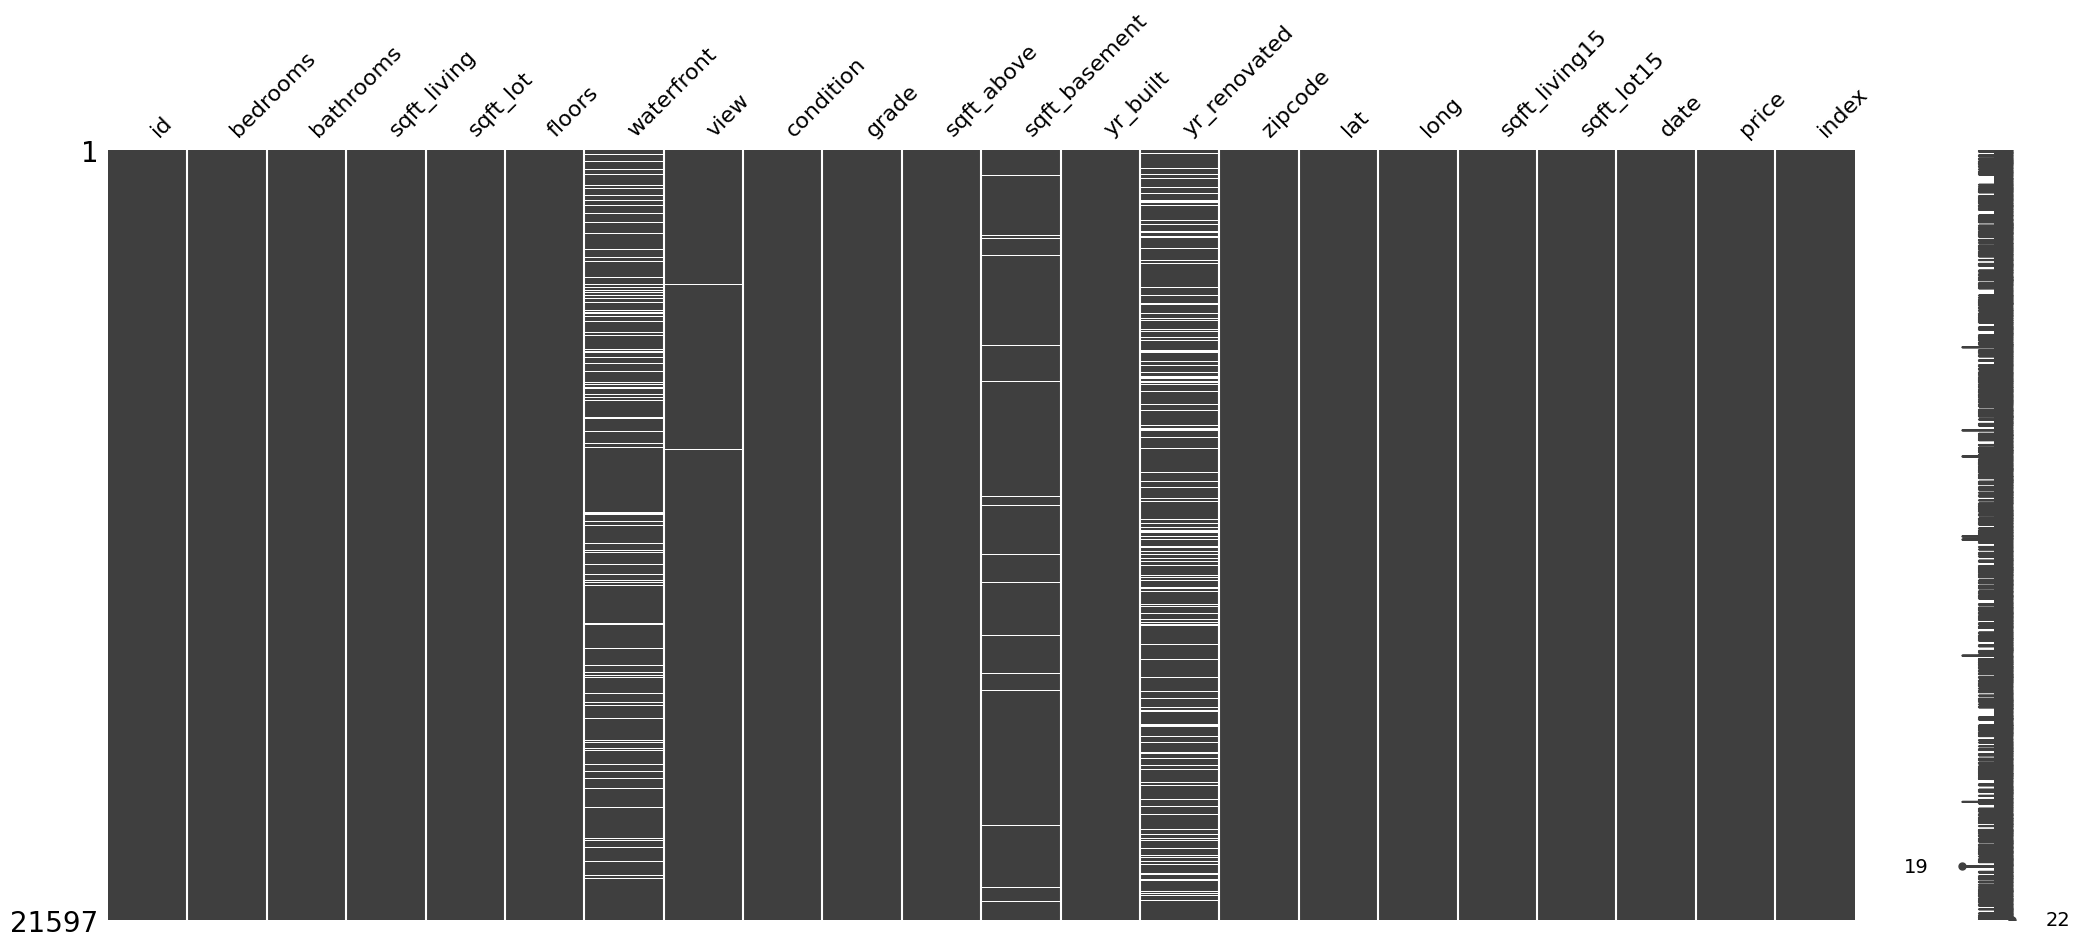

In [18]:
#let see now how clean is table.
msno.matrix(df2)

since I'm not interested in some columns, I can start dropping the invalid values

In [7]:
cleaned_df2 = df2.dropna(subset=['sqft_basement', 'yr_renovated'])
cleaned_df2.head(0)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,index


In [134]:
unique_views = cleaned_df2['view'].unique()
indices = {view: cleaned_df2[cleaned_df2['view'] == view].index.tolist() for view in unique_views}

#print("Unique views:", unique_views)
# print("Indices for each unique view:", indices)

----------
# filtering
since I'm not interested in the houses whose waterfront has 0.0 values because it predicts the non-waterfront house

In [21]:
print(f"numbers of rows : {cleaned_df2 .shape[0]}")
print(f"missing values in view : {round(cleaned_df2 .view.isna().sum()/cleaned_df2 .shape[0]*100,2)} %")
print(f"missing values in basement : {round(cleaned_df2 .sqft_basement.isna().sum()/cleaned_df2 .shape[0]*100,2)} %")
print(f"missing values in renovated : {round(cleaned_df2 .yr_renovated.isna().sum()/cleaned_df2 .shape[0]*100,2)} %")
print(f"missing values in data frame : {round(cleaned_df2 .isna().sum().sum()/(cleaned_df2 .shape[0]*cleaned_df2 .shape[1])*100,2)} %")

numbers of rows : 17384
missing values in view : 0.28 %
missing values in basement : 0.0 %
missing values in renovated : 0.0 %
missing values in data frame : 0.52 %


The NaN values could be filled with any number just to recognize. For an optical reason I choose 55 :)

In [11]:
df2_copy55= cleaned_df2 .copy()
df2_copy55 = df2_copy55.fillna({'waterfront': 55})
df2_copy55.head(0)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,index


lets check the houses on the map and see what can I figure out

<Axes: >

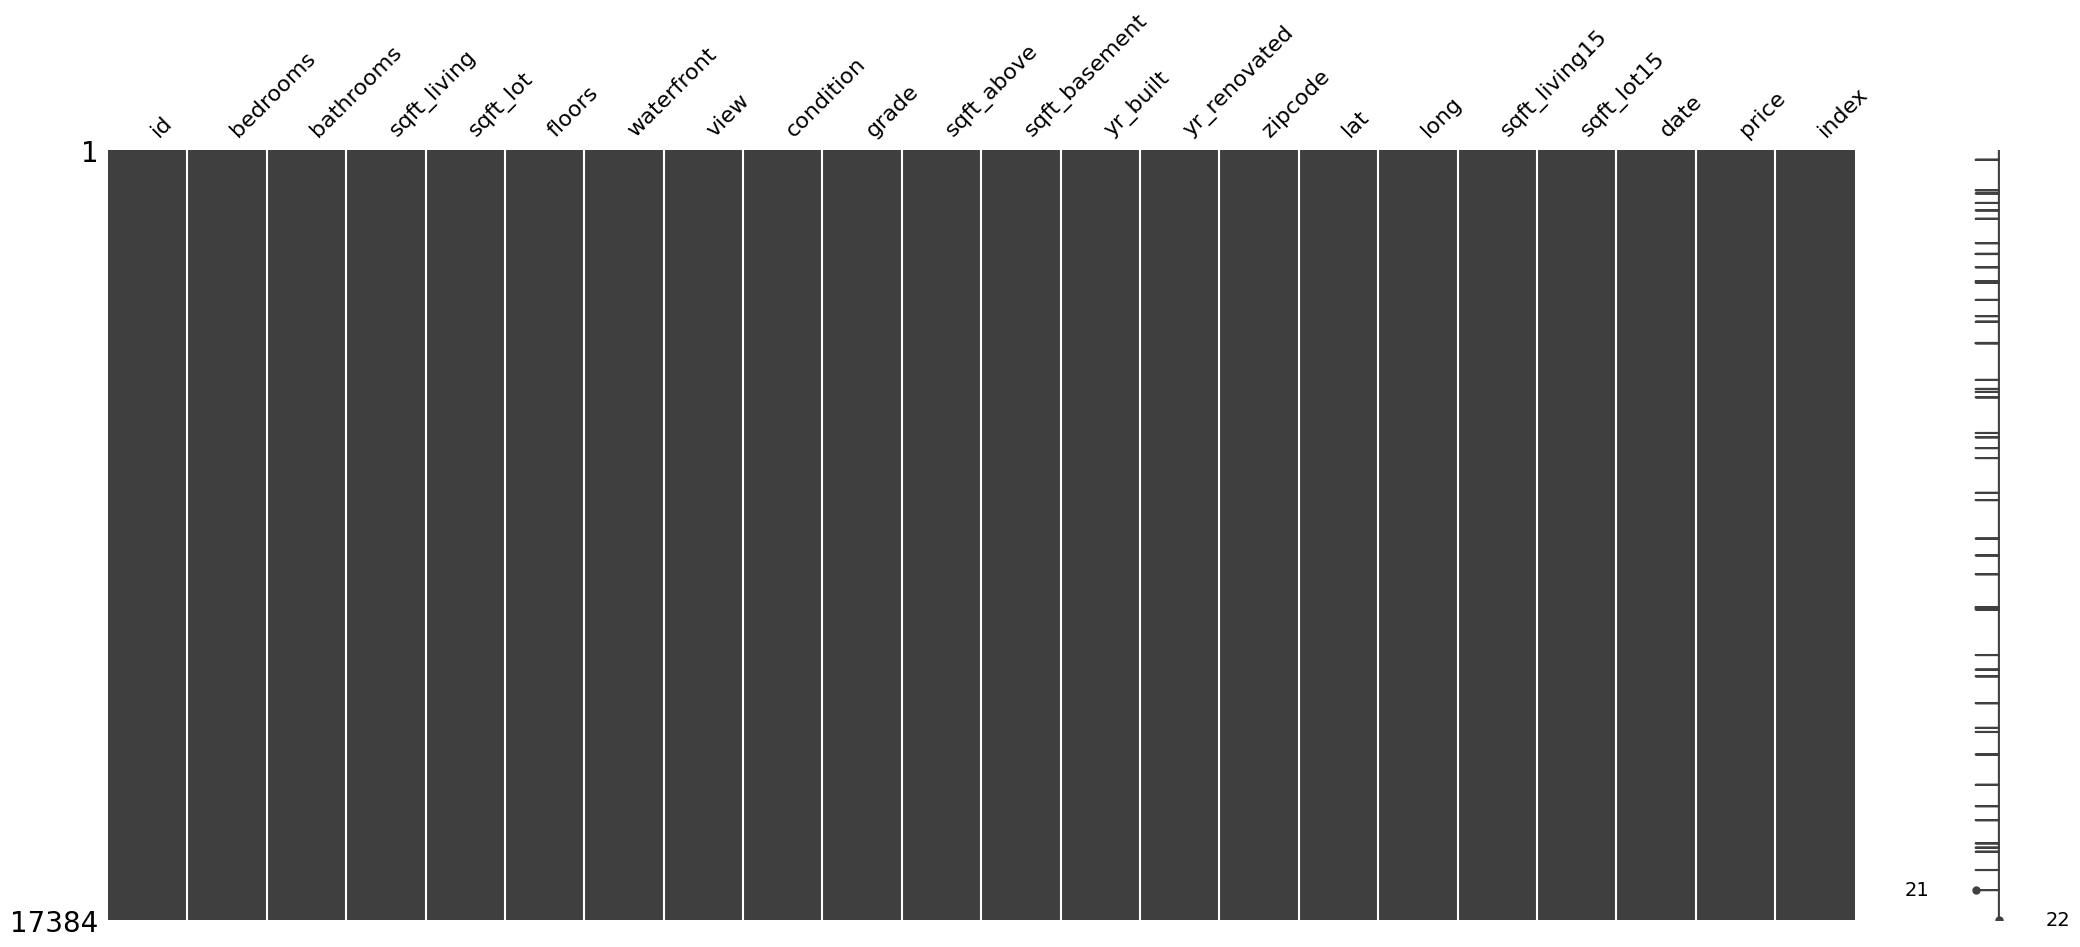

In [23]:
msno.matrix(df2_copy55)

-------

In [28]:
# Convert 'waterfront' column to categorical variable
df2_copy55['waterfront'] = pd.Categorical(df2_copy55['waterfront'], categories=[1.0, 55.0, 0.0])

# Create the figure with the specified category orders
fig = px.scatter_mapbox(df2_copy55, lat="lat", lon="long", hover_name="id", hover_data=["zipcode", "sqft_lot15", "bedrooms", "waterfront"],
                        color="waterfront", color_discrete_map={1.0: "blue", 55.0: "yellow", 0.0: "red"},
                        zoom=6, height=400)

# Update layout
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
    ])
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# Show the figure
fig.show()

In [29]:
df2_copy55[df2_copy55["waterfront"] == 55]["waterfront"].value_counts()

waterfront
55.0    1926
1.0        0
0.0        0
Name: count, dtype: int64

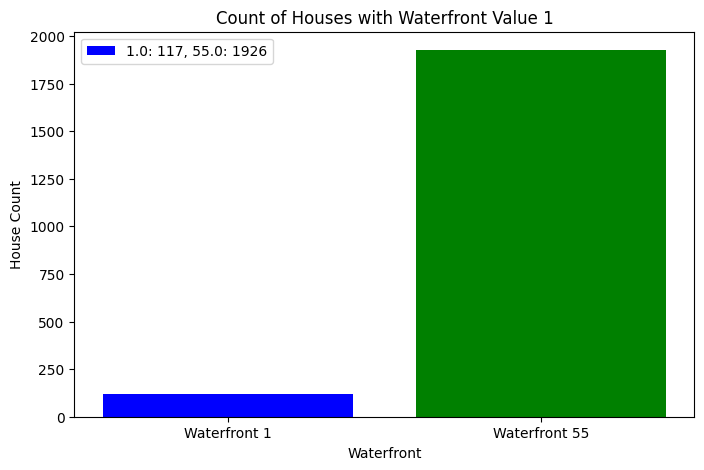

In [32]:

# Filter the DataFrame for 'waterfront' = 1.0
waterfront_1_data = df2_copy55[df2_copy55['waterfront'] == 1.0]
waterfront_55_data = df2_copy55[df2_copy55['waterfront'] == 55.0]

# Get the count of houses with 'waterfront' = 1.0
house_count_1 = len(waterfront_1_data)
house_count_55 = len(waterfront_55_data)
# Plot the count as a bar chart
plt.bar(['Waterfront 1', 'Waterfront 55'], [house_count_1, house_count_55], color =['blue','green'])


# Add count as legend
plt.legend([f'1.0: {house_count_1}, 55.0: {house_count_55}'], loc ='upper left')

# Set plot labels and title
plt.xlabel('Waterfront')
plt.ylabel('House Count')
plt.title('Count of Houses with Waterfront Value 1')

# Show plot
plt.show()

# dropping the 0.0 form the waterfront

In [12]:
df1_new = df2_copy55.copy()
df1_new.drop(df1_new[df1_new['waterfront'] == 0.0].index, inplace=True)
df1_new.head(0)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,index


------

# sqft_lot15 
 The square footage of the land lots for the 15 nearest neighbors needs to be determined. This implies that the larger Larry's lot is, the better he can keep his children away from the others."

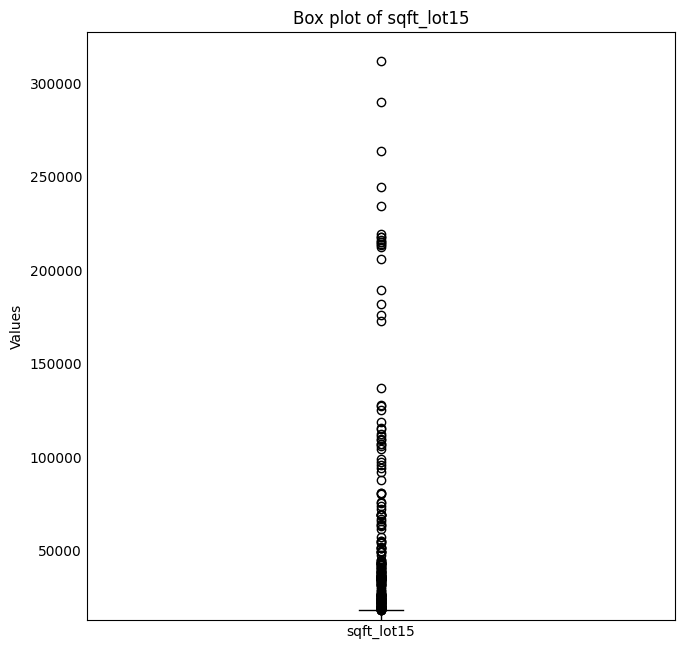

In [68]:
# Assuming df1_new is your DataFrame and 'sqft_lot15' is the column you're interested in

# Calculate the mean
mean_value = df1_new['sqft_lot15'].mean()

fig, ax = plt.subplots(figsize=(6,6))

# Create the box plot
ax.boxplot(df1_new['sqft_lot15'])

ax.set_title('Box plot of sqft_lot15')
ax.set_ylabel('Values')
ax.set_xticklabels(['sqft_lot15'])

# Calculate the lower limit for the y-axis as the mean value
# Note: This might hide parts of the boxplot that are below the mean.
ax.set_ylim(bottom=mean_value)

plt.show()


In [35]:
df1_new[['sqft_lot15', 'zipcode']].mean()

sqft_lot15   12775.718
zipcode      98077.874
dtype: float64

In [122]:
df1_new["sqft_lot15"].max()

871200.0

In [123]:
df1_new["sqft_lot15"].median()

7620.0

### A plot for the lot15 after reduction

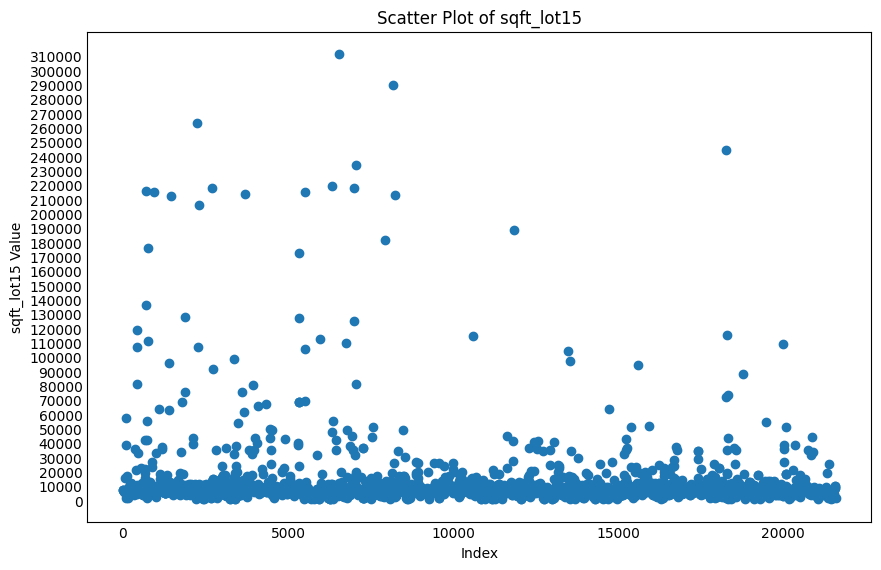

In [67]:
fig, ax = plt.subplots(figsize=(8,5))
plt.scatter(df1_new.index, df1_new['sqft_lot15'])
plt.title('Scatter Plot of sqft_lot15')
plt.xlabel('Index')
plt.ylabel('sqft_lot15 Value')

# Set y-axis ticks to increment every 10,000
plt.yticks(range(0, int(df1_new['sqft_lot15'].max()) + 1, 10000))

plt.show()

### Only values less than 25,000 are required.

### df1_new1 taken from df1_new

In [13]:
df1_new1 = df1_new.copy()
df1_new1.drop(df1_new1[df1_new1['sqft_lot15'] <= 25000].index, inplace=True)
df1_new1.head(0)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,index


### The number of rows is now reduced to 157, making it suitable for further analysis.

------

## zipcode 
### To assess how well the house may suit Mr. Sander.
### check the zipcode = central zipcodes    
* 98155 (Shoreline)
* 98118 (Columbia City, Rainier Valley)
* 98023 (Federal Way)
* 98117 (Ballard)
* 98144 (Central District)
* 98029 (Issaquah)
* 98004 (Bellevue)
* 98070
----------

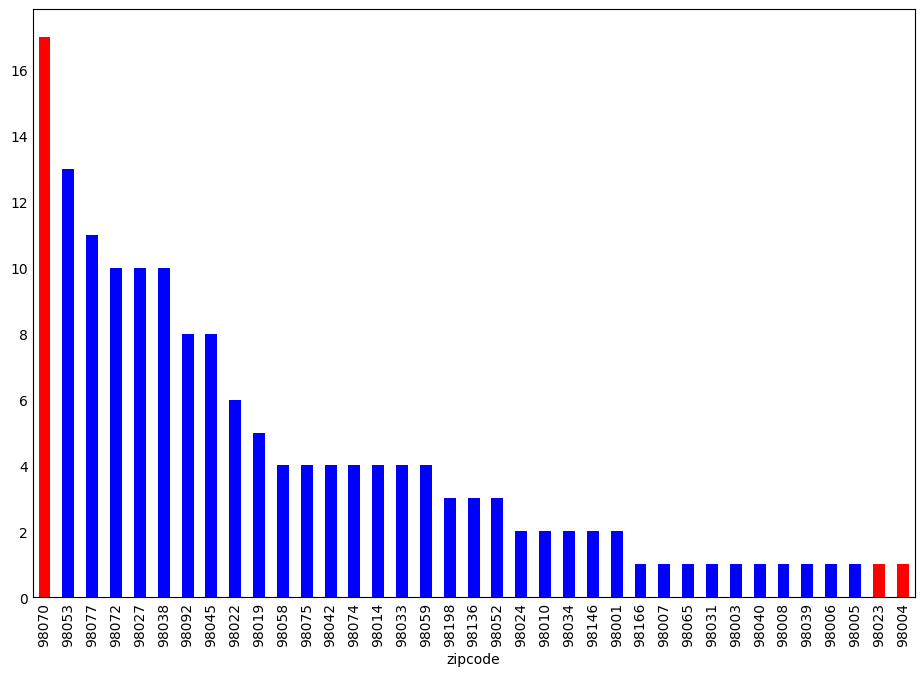

In [103]:
df1_new1['zipcode'] = df1_new1['zipcode'].astype(int)
# Count the occurrences of each zip code in the 'zipcode' column
zipcode_counts = df1_new1['zipcode'].value_counts()

# Apply colors using a list comprehension
colors = ['red' if zipcode in [98155, 98118, 98023, 98117, 98144, 98029, 98004, 98070] else 'blue' for zipcode in zipcode_counts.index]

# Plot the bar chart
plt.figure(figsize=(9, 6))
zipcode_counts.plot(kind='bar', color=colors)
plt.xticks(rotation=90)
plt.show()

###  Define the list of zip codes to keep 98070, 98023 and 98004

In [14]:
# Define the list of zip codes to keep
zipcodes_to_keep = [98004,98023, 98070]

# Filter the DataFrame to keep only the rows with the desired zip codes
df1_new2= df1_new1[df1_new1['zipcode'].isin(zipcodes_to_keep)]
df1_new2.head(0)


,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,index


-----------


## The price

### Given the limited budget, I select prices below the mean. This allows for a comparison of all house prices before and after filtering.

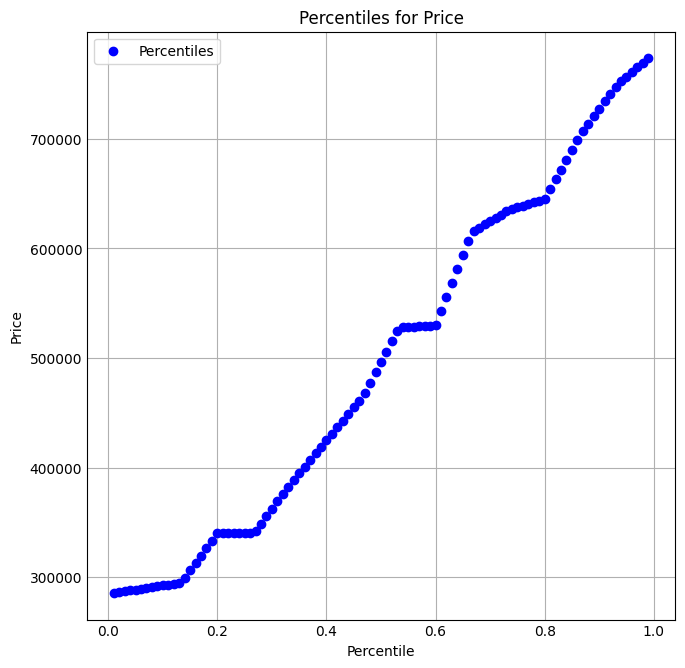

In [125]:
percentiles = df1_new2['price'].quantile([i/100 for i in range(1, 100)])

# Create a scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(percentiles.index, percentiles.values, color='blue', label='Percentiles')

# Add title, labels, legend, and grid
plt.title('Percentiles for Price')
plt.xlabel('Percentile')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
df1_new2.drop(df1_new2[df1_new2['price'] >= df1_new2.price.mean()].index, inplace = True)
df1_new2.head(0)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,index


-----------

### dropping the 1-2 bedrooms from the table

In [17]:
df1_new2.drop(df1_new2[(df1_new2['bedrooms'] == 1.0) | (df1_new2['bedrooms'] == 2.0)].index, inplace=True)
df1_new2.head(0)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,index


# presintation relevant

In [126]:
df1_new2['waterfront'] = pd.Categorical(df1_new2['waterfront'], categories=[1.0, 55.0])

fig = px.scatter_mapbox(df1_new2, lat="lat", lon="long", hover_name="id", hover_data=["zipcode", "sqft_lot15", "bedrooms", "waterfront"],
                        color="waterfront", color_discrete_map={1.0: "blue", 55.0: "yellow"},
                        zoom=6, height=400)

fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
    ])
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# Show the figure
fig.show()


## Waterfront houses might interest Mr. Sander.

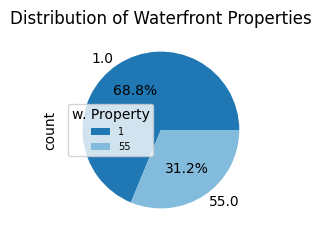

In [127]:
waterfront_counts = df1_new2["waterfront"].value_counts()

# Plot the pie chart with percentages
waterfront_counts.plot(kind="pie", autopct='%1.1f%%')

# Add a title
plt.title("Distribution of Waterfront Properties")

# Add legend with explanation of waterfront values and adjust font size
plt.legend(title="w. Property",
           labels={"1": "Waterfront (1)", "55": "Potential Waterfront (55)"},
           prop={'size': 7})

# Display the plot
plt.show()

# check the grade 

In [129]:
df1_new2["grade"].value_counts()
#df1.grade.unique()
#df1["grade"].unique()

grade
6     6
7     3
8     2
9     2
5     2
10    1
Name: count, dtype: int64

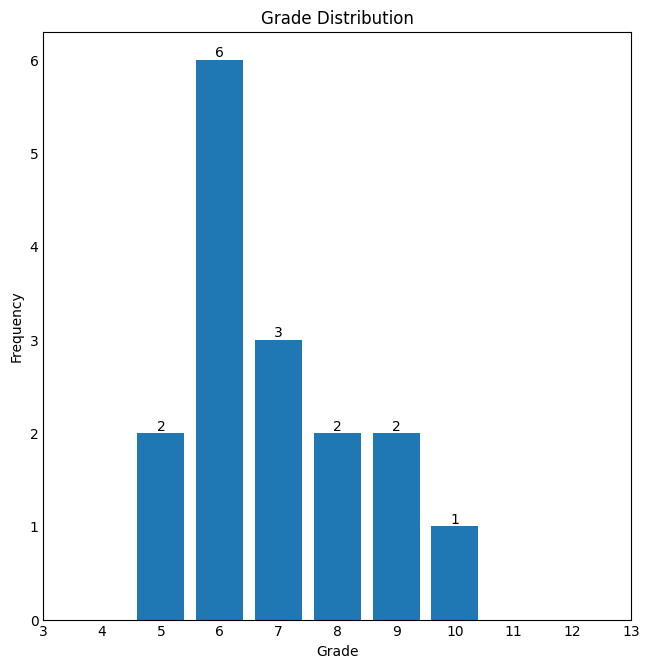

In [131]:
grade_counts = df1_new2['grade'].value_counts()


plt.figure(figsize=(6, 6))  # Set the size of the bar diagram
plt.bar(grade_counts.index, grade_counts)

# Add text annotations for each bar using lambda function
_ = list(map(lambda grade, count: plt.text(grade, count, str(count), ha='center', va='bottom'), grade_counts.index, grade_counts))

plt.xlabel("Grade")
plt.ylabel("Frequency")
plt.title("Grade Distribution")
plt.xticks(sorted(set(df1['grade'])))  # Set x-axis ticks to unique values in the "grade" column
plt.show()


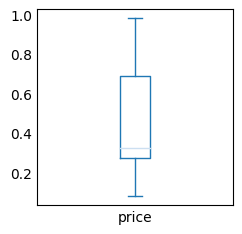

In [133]:
df1_new2 = pd.DataFrame(np.random.rand(10, 1), columns=["price"])
stacked_df = df1_new2.stack()
stacked_df = df1_new2.plot.box()